# Nodal cycle

Investigate the effect of the nodal modulation of steric sea level changes on the equilibrium tide and compare the resulting signal with the observed nodal cycle in mean sea level.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial import Polynomial
import xarray as xr
import cartopy.crs as ccrs

import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [32]:
main = '/Users/dewilebars/Documents/PaperWriting/2023/PaperNodalTides/DocSterre/manuscript/data/'
data_tidegauges_dir = f'{main}/input/tide gauges/rlr_annual/'

path_steric = '/Users/dewilebars/Projects/SLBudget/data/DataSteric/'

### Function to determine the tide gauge ID and latitude

In [3]:
latitude_netherlands = 53
latitude_brest = 48
latitude_newlyn = 50
latitude_stavanger = 59
latitude_cuxhaven = 54
latitude_cascais = 39
latitude_esbjerg = 55
latitude_bergen = 60
latitude_northshields = 55

In [4]:
def select_id(region):
    if region == 'Cascais':
        latitude = latitude_cascais
        tg_id = 52
    elif region == 'Brest':
        latitude = latitude_brest
        tg_id = 1
    elif region == 'Newlyn':
        latitude = latitude_newlyn
        tg_id = 202
    elif region == 'Vlissingen':
        latitude = latitude_netherlands
        tg_id = 20
    elif region == 'Hoek van Holland':
        latitude = latitude_netherlands
        tg_id = 22
    elif region == 'IJmuiden':
        latitude = latitude_netherlands
        tg_id = 32
    elif region == 'Den Helder':
        latitude = latitude_netherlands
        tg_id = 23
    elif region == 'Harlingen':
        latitude = latitude_netherlands
        tg_id = 25
    elif region == 'Delfzijl':
        latitude = latitude_netherlands
        tg_id = 24
    elif region == 'Cuxhaven':
        latitude = latitude_cuxhaven
        tg_id = 7
    elif region == 'Esbjerg':
        latitude = latitude_esbjerg
        tg_id = 80
    elif region == 'North Shields':
        latitude = latitude_northshields
        tg_id = 95
    elif region == 'Stavanger':
        latitude = latitude_stavanger
        tg_id = 47
    elif region == 'Bergen':
        latitude = latitude_bergen
        tg_id = 58
    return tg_id, latitude

In [5]:
tg_id, latitude = select_id('Brest')

In [10]:
def tg_lat_lon(input_dir, tg_id):
    '''Return tide gauge latitude, longitude location given the id as input'''
    
    names_col = ('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality')
    filelist_df = pd.read_csv(f'{input_dir}filelist.txt', sep=';', header=None, names=names_col)
    filelist_df = filelist_df.set_index('id')
    
    return filelist_df.loc[tg_id].lat, filelist_df.loc[tg_id].lon

In [11]:
lats, lons = tg_lat_lon(data_tidegauges_dir, tg_id)

### Bathymetry data

Import bathymetry data and define the boundaries. The ranges of latitude and longitude are also defined.

ETOPO 2022 data can be downloaded here: https://www.ncei.noaa.gov/products/etopo-global-relief-model

In [24]:
bed = xr.open_dataset(f'{main}input/ETOPO_2022_v1_60s_N90W180_bed.nc')

top = bed.z
min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
top = top.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

lon = top.lon
lat = top.lat

## Location of the 14 tide gauges and the extended Bay of Biscay

In [25]:
regions = ['Cascais','Brest','Newlyn','Vlissingen','Hoek van Holland','IJmuiden','Den Helder','Harlingen','Delfzijl','Cuxhaven','Esbjerg','North Shields','Stavanger','Bergen']
lats = np.zeros(len(regions))
lons = np.zeros(len(regions))

for i in range(len(regions)):
    tg_id, latitude = select_id(regions[i])
    lats2, lons2 = tg_lat_lon(data_tidegauges_dir, tg_id)
    lats[i] = float(lats2)
    lons[i] = float(lons2)

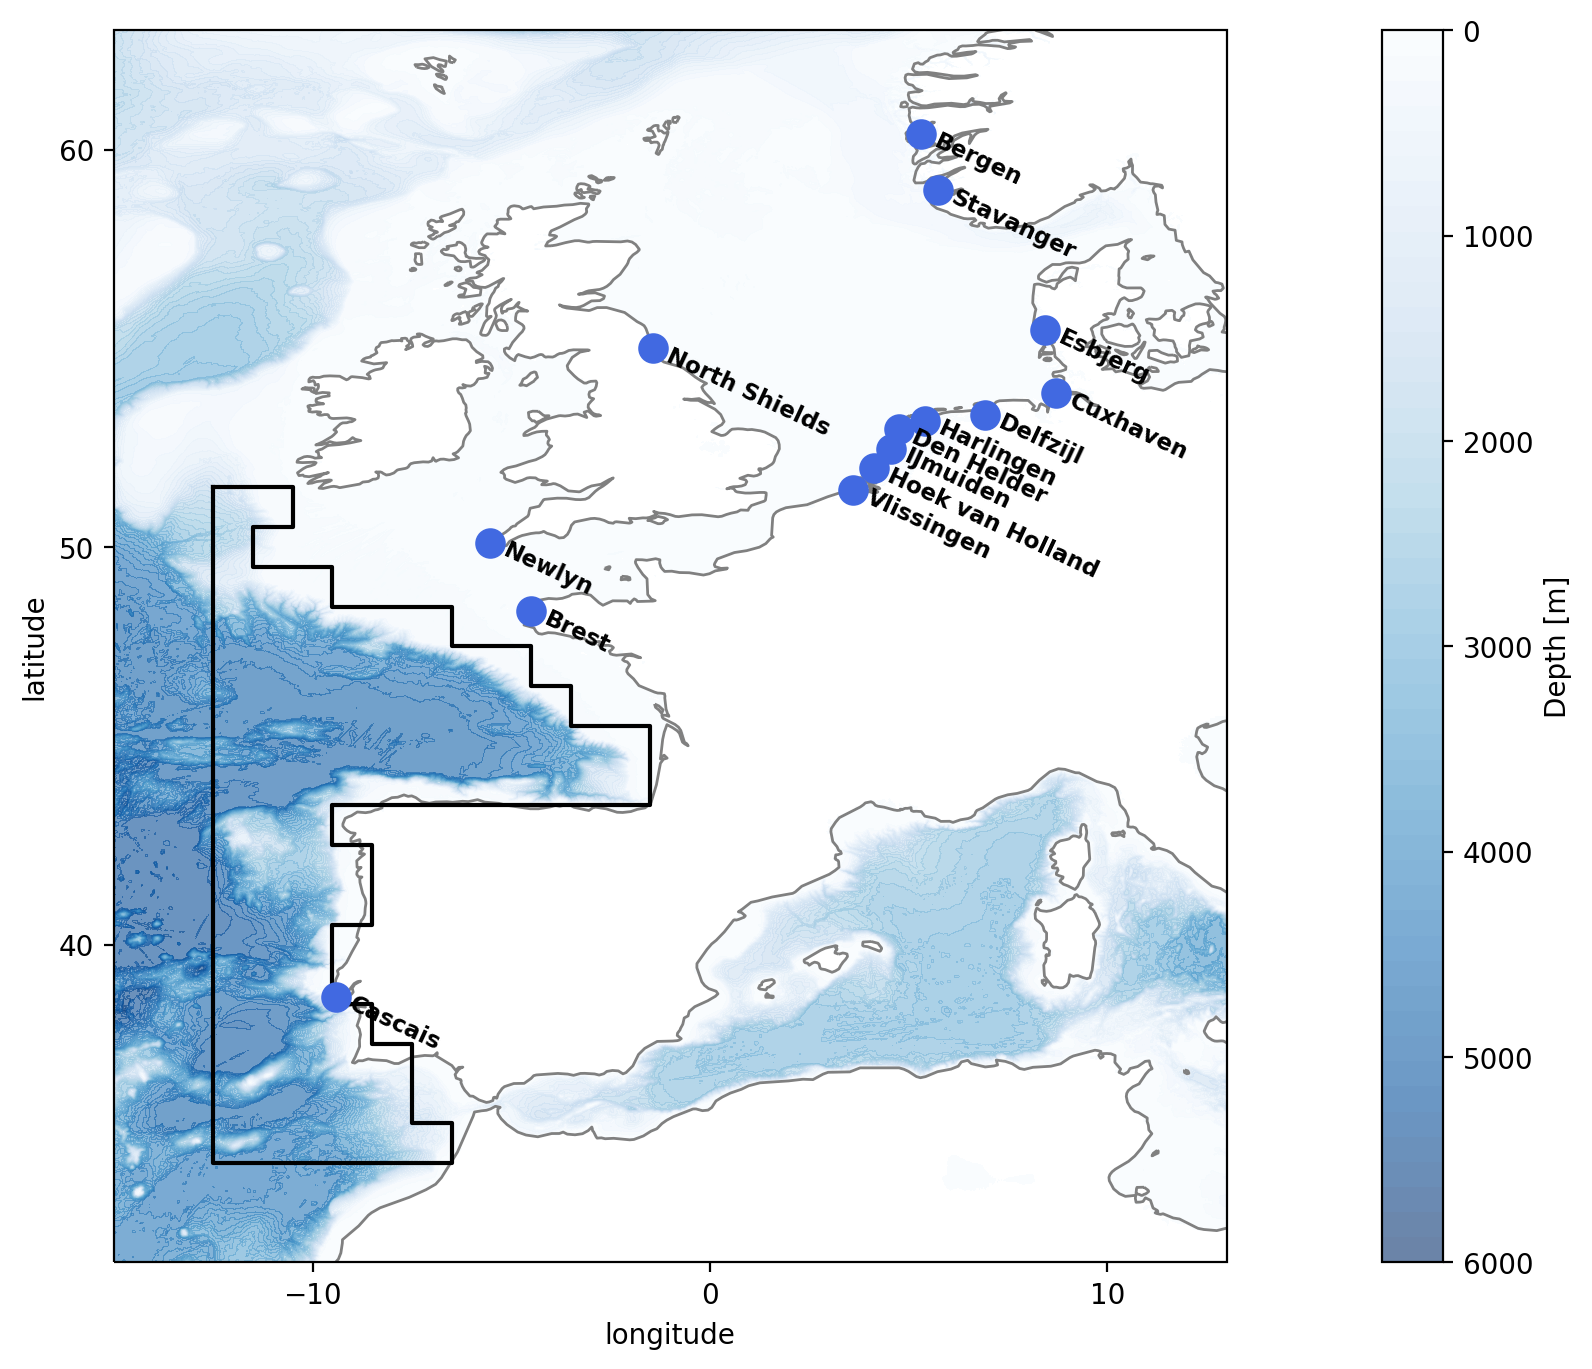

In [26]:
fig = plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())

levels = np.linspace(-6000, 0)

x = plt.contourf(lon, lat, top, 60, transform=ccrs.PlateCarree(),alpha=0.6,cmap='Blues_r',levels=levels,zorder=-1)

ax.coastlines(color='grey',zorder=0)

outline_x = np.array([-12.5,-10.5,-10.5,-11.5,-11.5,-9.5,-9.5,-6.5,-6.5,-4.5,-4.5,-3.5,-3.5,-1.5,-1.5,-9.5,-9.5,-8.5,-8.5,-9.5,-9.5,-8.5,-8.5,-7.5,-7.5,-6.5,-6.5,-12.5,-12.5])
outline_y = np.array([51.5,51.5,50.5,50.5,49.5,49.5,48.5,48.5,47.5,47.5,46.5,46.5,45.5,45.5,43.5,43.5,42.5,42.5,40.5,40.5,38.5,38.5,37.5,37.5,35.5,35.5,34.5,34.5,51.5])

plt.plot(outline_x,outline_y,transform=ccrs.PlateCarree(),color='black',zorder=1)

s_ampl = 100

for i in range(len(lats)):
    plt.text(lons[i]+0.3,lats[i]-0.3,regions[i],fontsize='small',fontweight='bold',rotation_mode='anchor',rotation=335)

plt.scatter(lons, lats,transform=ccrs.PlateCarree(),s=s_ampl,zorder=2,color='royalblue')

ax.set_xticks([-20,-10,0,10], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60], crs=ccrs.PlateCarree())
ax.set_ylim([32,63])
ax.set_xlim([-15,13]);
ax.set_ylabel('latitude')
ax.set_xlabel('longitude');

cbar = plt.colorbar(x,label='Depth [m]')
cbar.set_ticks([0,-1000,-2000,-3000,-4000,-5000,-6000])
cbar.set_ticklabels([0,1000,2000,3000,4000,5000,6000]);

#plt.savefig(path + '/figures/overview_stations.png', dpi=200)

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
def thickness_from_depth(depth):
    '''Define a thickness Data Array from depth coordinate'''
    midp = (np.array(depth[1:])+np.array(depth[:-1]))/2
    midp = np.insert(midp, 0, np.array([0]))
    midp = np.insert(midp, len(midp), np.array(depth[-1]) + 
                     (np.array(depth[-1]) - np.array(depth[-2])))
    thick = midp[1:] - midp[:-1]
    thick_da = xr.DataArray(thick, coords={'depth': depth[:]}, dims='depth')
    return thick_da

def StericSL2(data_source, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'EN4_22':
        density_ds = xr.open_dataset(f'{main}input/density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da
    
    rho_0 = density_ds.density[0 ,0 ,: ,:];
    
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL

In [29]:
def gam_model(reg_df, regression_formula, summary=False):

    bs_ts = BSplines(reg_df.index, df=gam_df, degree=3) 
    # alpha is the penalization weight for smooth terms
    gam_bs_ts = GLMGam.from_formula(regression_formula, data=reg_df, smoother=bs_ts, alpha=gam_alpha)
    res_gam = gam_bs_ts.fit()

    if summary:
        print(res_gam.summary())
        
    return res_gam

def store_results_df(reg_df, res_gam, reg_list):

    # Store model results in a dataframe
    model_results_df = pd.DataFrame(index=reg_df.index)

    for proc in reg_list: 
        model_results_df[proc] = reg_df[proc]*res_gam.params[proc]

    model_results_df['trend'] = res_gam.partial_values(0, True)[0]
    model_results_df['total'] = model_results_df.sum(axis=1)

    if 'nod1' in res_gam.params.index:
        model_results_df['nodal_steric'] = model_results_df['nod1'] + model_results_df['nod2']

    return model_results_df

def compute_model(reg_df):
    
    reg_list = ['nod1', 'nod2']
    regression_formula = 'Steric ~ nod1 + nod2'
    res_gam = gam_model(reg_df, regression_formula, summary=False)
    model_results_df = store_results_df(reg_df, res_gam, reg_list)
    
    return model_results_df, res_gam

## GAM fit through steric changes in sea level and tide gauge (Delfzijl) data

In [30]:
max_depth = 400
region = "EBB"
start_year = 1900
end_year = 2020

In [36]:
def steric_masks_north_sea(da, mask_name):
    '''Define a few masks to use to compute the steric expansion that is felt 
    in the North Sea.
    The input data array needs to have a latitude/longitude coordinates with
    longitudes from -180 to 180.'''
    
    if mask_name == 'ENS':
        # Extended North Sea mask
        lat = np.array(da.lat)
        lon = np.array(da.lon)
        LatAr = np.repeat(lat[:,np.newaxis], len(lon), 1)
        LatAr = xr.DataArray(LatAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})
        LonAr = np.repeat(lon[np.newaxis,:], len(lat), 0)
        LonAr = xr.DataArray(LonAr, dims=['lat', 'lon'], 
                             coords={'lat' : lat, 'lon' : lon})

        mask_med = xr.where(np.isnan(da[0,0,:,:]), np.nan, 1)
        mask_med1 = mask_med.where((LonAr >= -8) & (LatAr <= 42) )
        mask_med1 = xr.where(np.isnan(mask_med1), 1, np.nan)
        mask_med2 = mask_med.where((LonAr >= 1) & (LatAr <= 48) )
        mask_med2 = xr.where(np.isnan(mask_med2), 1, np.nan)
        mask_med = mask_med * mask_med1 * mask_med2

        mask = xr.where(np.isnan(da[0,0,:,:]), np.nan, 1)
        mask = mask.where(mask.lon <= 7)
        mask = mask.where(mask.lon >= -16)
        mask = mask.where(mask.lat <= 69) #Normal value: 60 or 69
        mask = mask.where(mask.lat >= 33)
        mask = mask * mask_med

    elif mask_name == 'EBB':
        # Extended bay of Biscay
        mask = xr.where(np.isnan(da[0,:,:,:]
                                 .sel(depth=2000, method='nearest')), np.NaN, 1)
        mask = mask.where(mask.lon <= -2)
        mask = mask.where(mask.lon >= -12)
        mask = mask.where(mask.lat <= 52)
        mask = mask.where(mask.lat >= 35)

    elif mask_name == 'BB':
        # Bay of Biscay
        mask = xr.where(np.isnan(da[0,:,:,:]
                                 .sel(depth=500, method='nearest')), np.NaN, 1)
        mask = mask.where(mask.lon <= 0)
        mask = mask.where(mask.lon >= -10)
        mask = mask.where(mask.lat <= 50)
        mask = mask.where(mask.lat >= 44)    
        
    elif mask_name == 'NWS':
        # Norwegian Sea
        mask = xr.where(np.isnan(da[0,:,:,:]
                                 .sel(depth=2000, method='nearest')), np.NaN, 1)
        mask = mask.where(mask.lon <= 8)
        mask = mask.where(mask.lon >= -10)
        mask = mask.where(mask.lat <= 69)
        mask = mask.where(mask.lat >= 60)
        
    else:
        print('ERROR: mask_name argument is not available')

    del mask['depth']
    del mask['time']
    
    return mask

In [37]:
def StericSL(data_source, mask_name, min_depth, max_depth, window):
    '''Compute the steric sea level in cm integrated between two depth levels 
    given in meters. '''
    
    if data_source == 'IAP':
        density_ds = xr.open_mfdataset(path_steric +
                        'density_teos10_IAP/density_teos10_iap_*.nc')
    elif data_source == 'EN4_21':
        density_ds = xr.open_dataset(path_steric + 
                       'density_teos10_EN421f_analysis_g10/' + 
                       'density_teos10_en4_1900_2019.nc')
    elif data_source == 'EN4_22':
        density_ds = xr.open_dataset(path_steric + 
                       'density_teos10_en422_g10_1900_2022.nc')
    else:
        print('ERROR: data_source not defined')
    
    thick_da = thickness_from_depth(density_ds.depth)
    SumDens = density_ds.density * thick_da

    mask = steric_masks_north_sea(density_ds.density, mask_name)
    
    SumDens = (SumDens * mask).mean(dim=['lat', 'lon'])
    rho_0 = (density_ds.density[0 ,0 ,: ,:] * mask).mean(dim=['lat', 'lon'])
    StericSL = (- SumDens.sel(depth=slice(min_depth,max_depth)).sum(dim='depth') 
                / rho_0) * 100
    StericSL = StericSL - StericSL.sel(time=slice(1940,1960)).mean(dim='time')
    StericSL.name = 'Steric'
    StericSL_df = StericSL.to_dataframe()
    del StericSL_df['depth']
    
    if window > 1:
        frac = window/StericSL_df.shape[0]
        StericSL_df['Steric'] = lowess(StericSL_df['Steric'], StericSL_df.index, 
                                       frac, return_sorted=False)
    
    return StericSL_df

In [38]:
StericSL_EBB_df = StericSL('EN4_22', 'EBB', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]

StericSL_df = StericSL_EBB_df

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:end_year]

In [39]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

In [40]:
gam_df = len(t)//2
gam_alpha = 5000

In [41]:
res_nr, res_full_nr = compute_model(reg_df)

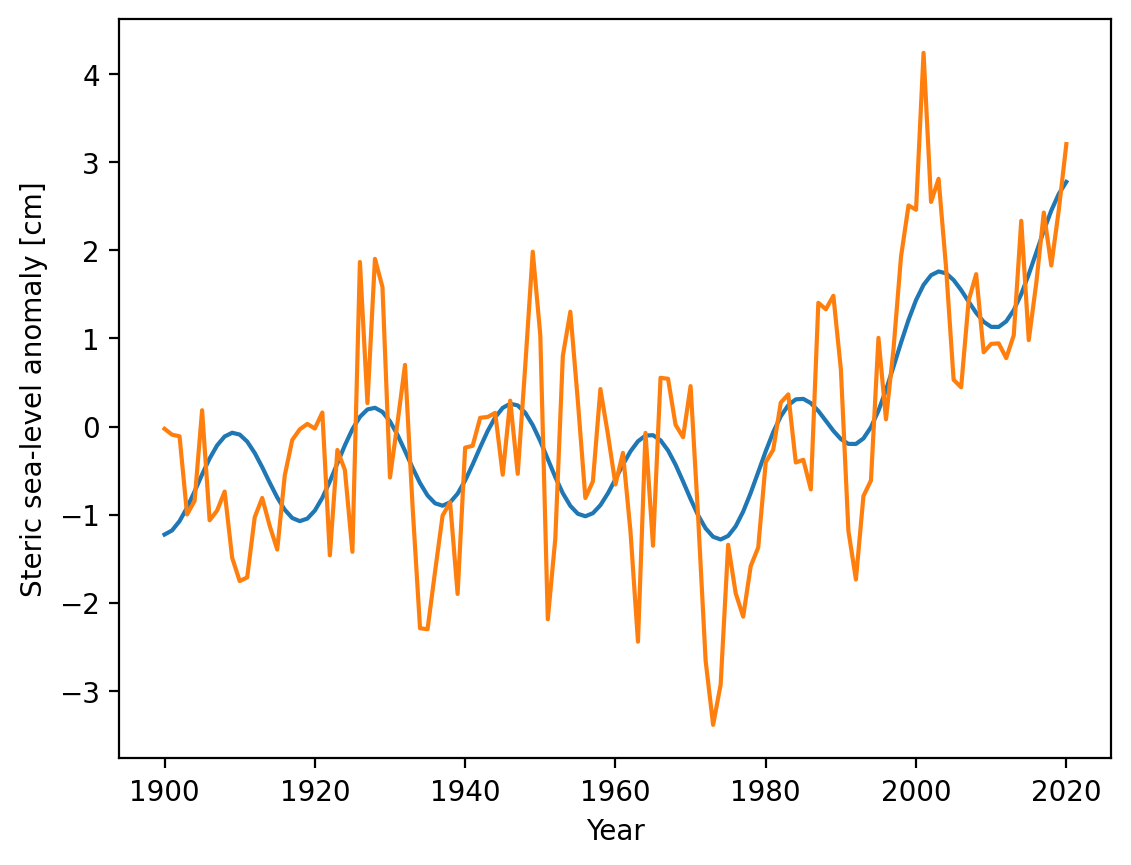

In [42]:
plt.plot(res_nr["total"])
plt.plot(StericSL_df[f"Steric_{region}"])

plt.ylabel('Steric sea-level anomaly [cm]')
plt.xlabel('Year');

#plt.savefig(path + '/figures/stericfit.png', dpi=150)

In [45]:
tg_na2 = pd.read_csv(main + 'output/tide_gauges/delfzijl_npa2.csv',index_col=0)

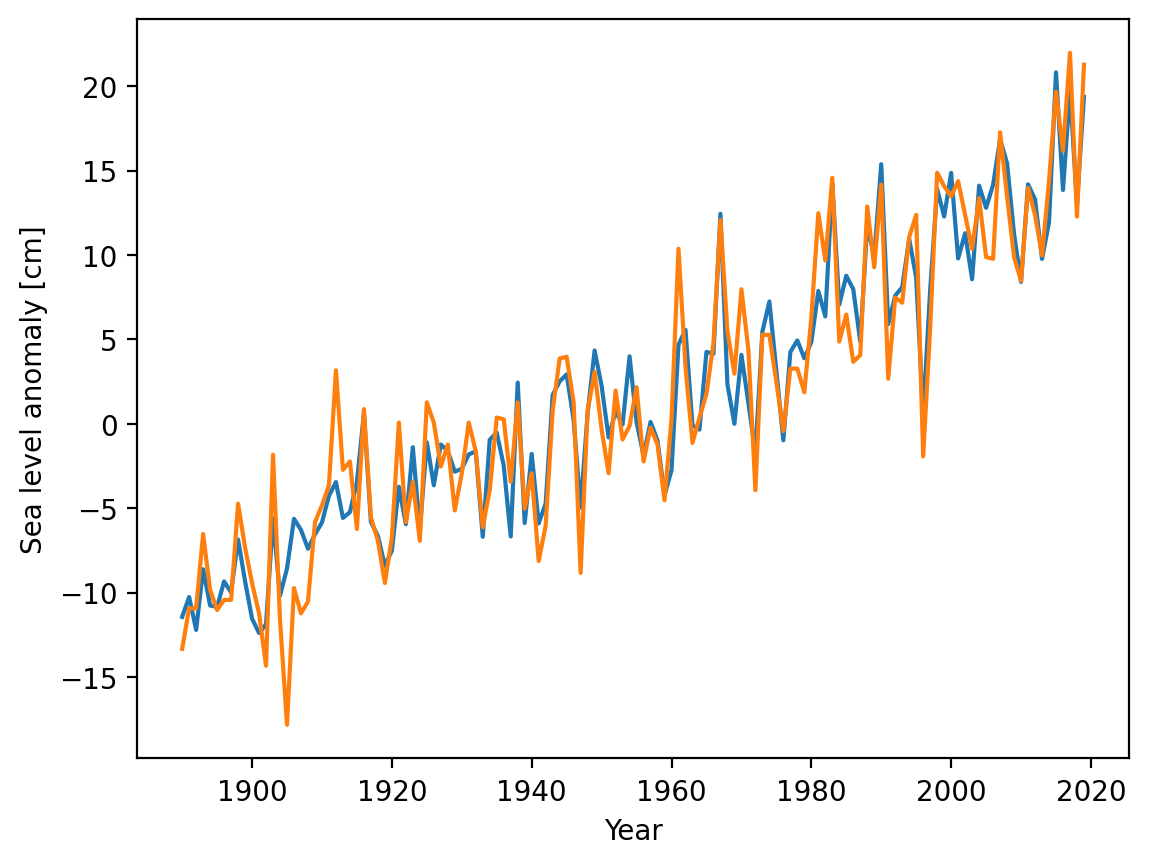

In [46]:
plt.plot(tg_na2['model'])
plt.plot(tg_na2['tide gauge'])

plt.ylabel('Sea level anomaly [cm]');
plt.xlabel('Year');

#plt.savefig(path + '/figures/tidegaugesfit.png', dpi=150)

## Nodal modulation of steric sea level changes, amplitude and phase

In [51]:
density_ds = xr.open_dataset(main +'input/density_teos10_en422_g10_1900_2022.nc')

ster = StericSL2('EN4_22',0,400,0)
ster = ster.loc[1960:]

In [52]:
ampl = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))
phase = np.zeros((len(ster[1,:,1]),len(ster[1,1,:])))

for i in range(len(ster[1,:,1])):
    for j in range(len(ster[1,1,:])):
        if ster[:,i,j].isnull().values.any() == False:
            reg_df = ster[:,i,j].to_dataframe()
            t = ster['time']

            reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
            reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
            res_nr, res_full_nr = compute_model(reg_df)
            
            ampl[i,j] = res_nr["nodal_steric"].loc[1993:2011].max()
            phase[i,j] = res_nr["nodal_steric"].loc[1993:2011].idxmax()
        else: 
            ampl[i,j] = 'NaN'

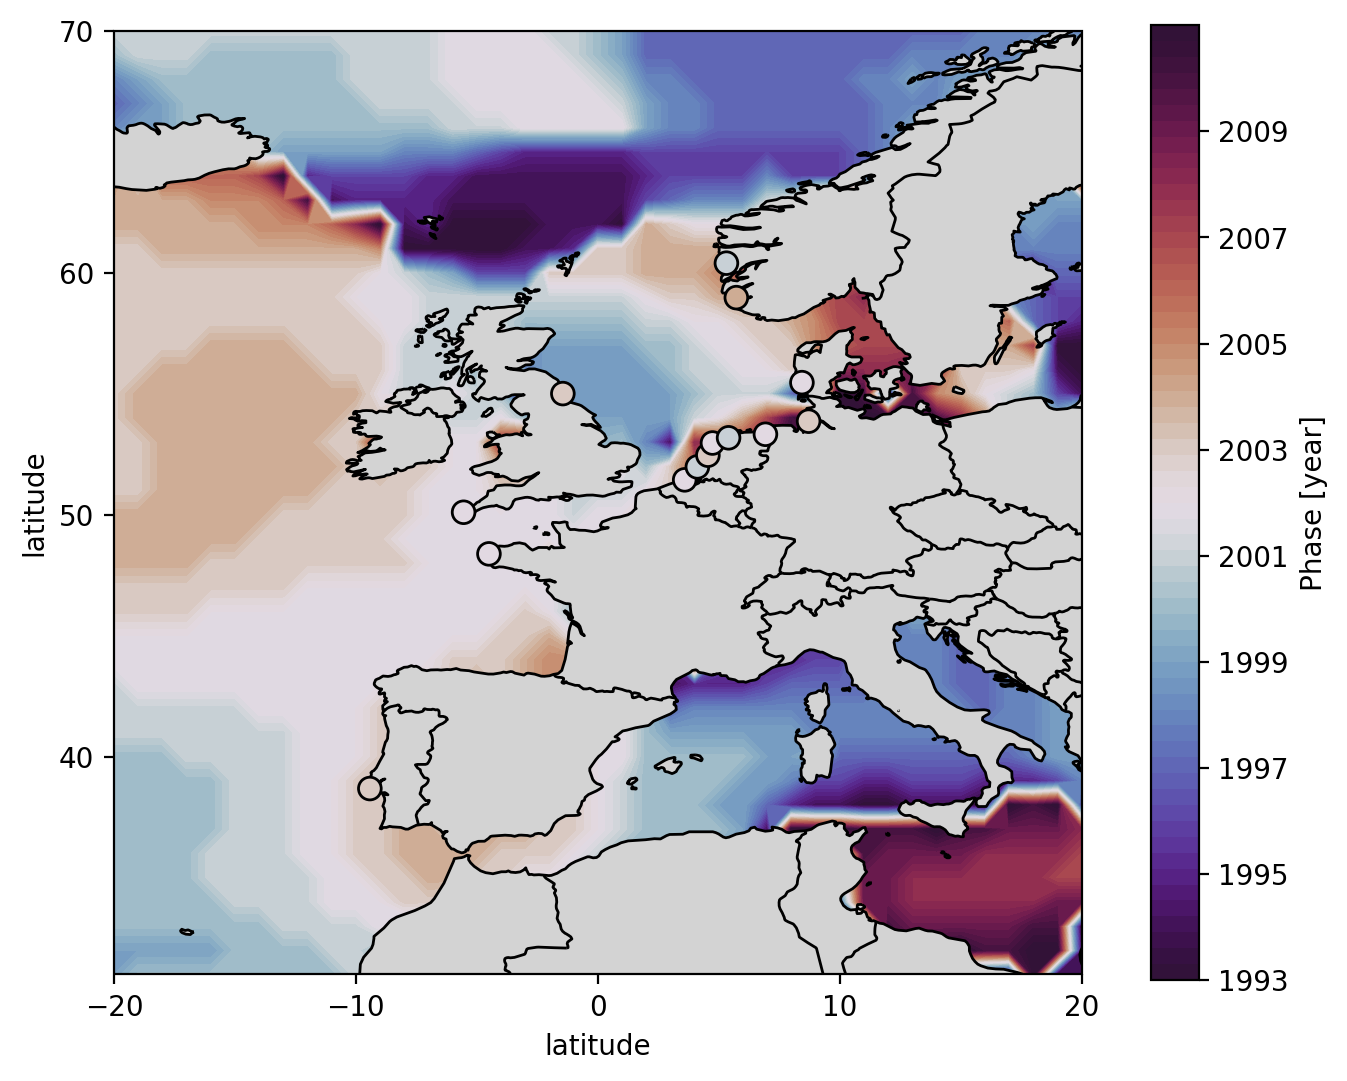

In [54]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

dampl = xr.DataArray(data=ampl,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))
dphase = xr.DataArray(data=phase,dims=["lat", "lon"],coords=dict(lon=(ster['lon']),
            lat=(ster['lat'])))

dphase = xr.where(dphase == 0, np.nan, dphase)

tg = pd.read_csv(main +'output/tide_gauges/tidegauges.csv',index_col=0)
tg_poe = tg['dP (obs-eq)']
tg_poe[0] = tg_poe[0]

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

min_lat = 30
max_lat = 71
min_lon = -20
max_lon = 20
density_ds2 = density_ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

lons = density_ds2['lon']
lats = density_ds2['lat']

dphase2 = dphase.interpolate_na(dim='lat')
dphase2 = dphase2.interpolate_na(dim='lon')

im = plt.contourf(lons, lats, dphase2, 60,transform=ccrs.PlateCarree(),cmap='twilight_shifted',antialiased=False,zorder=0)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,ticks=np.arange(1993,2011,2),label='Phase [year]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

lats2 = [38.683333,48.382850,50.103000,51.442222,51.977500,52.462222,52.964444,53.18,53.326389,53.866667,55.460833,55.007444,58.974339,60.398046]
lons2 = [-9.416667,-4.494838,-5.542833,3.596111,4.12000,4.554722,4.745000,5.409,6.933056,8.716667,8.441111,-1.439778,5.730121,5.320487]

s_ampl = tg_poe

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines()

ax.set_ylabel('latitude')
ax.set_xlabel('latitude')

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl/30,c=s_ampl,cmap='twilight_shifted',vmin=1993,vmax=2011,edgecolors='k',zorder=2);
#plt.savefig(path + '/figures/NodalPhaseStericSeaLevel_EN4.png', dpi=150)

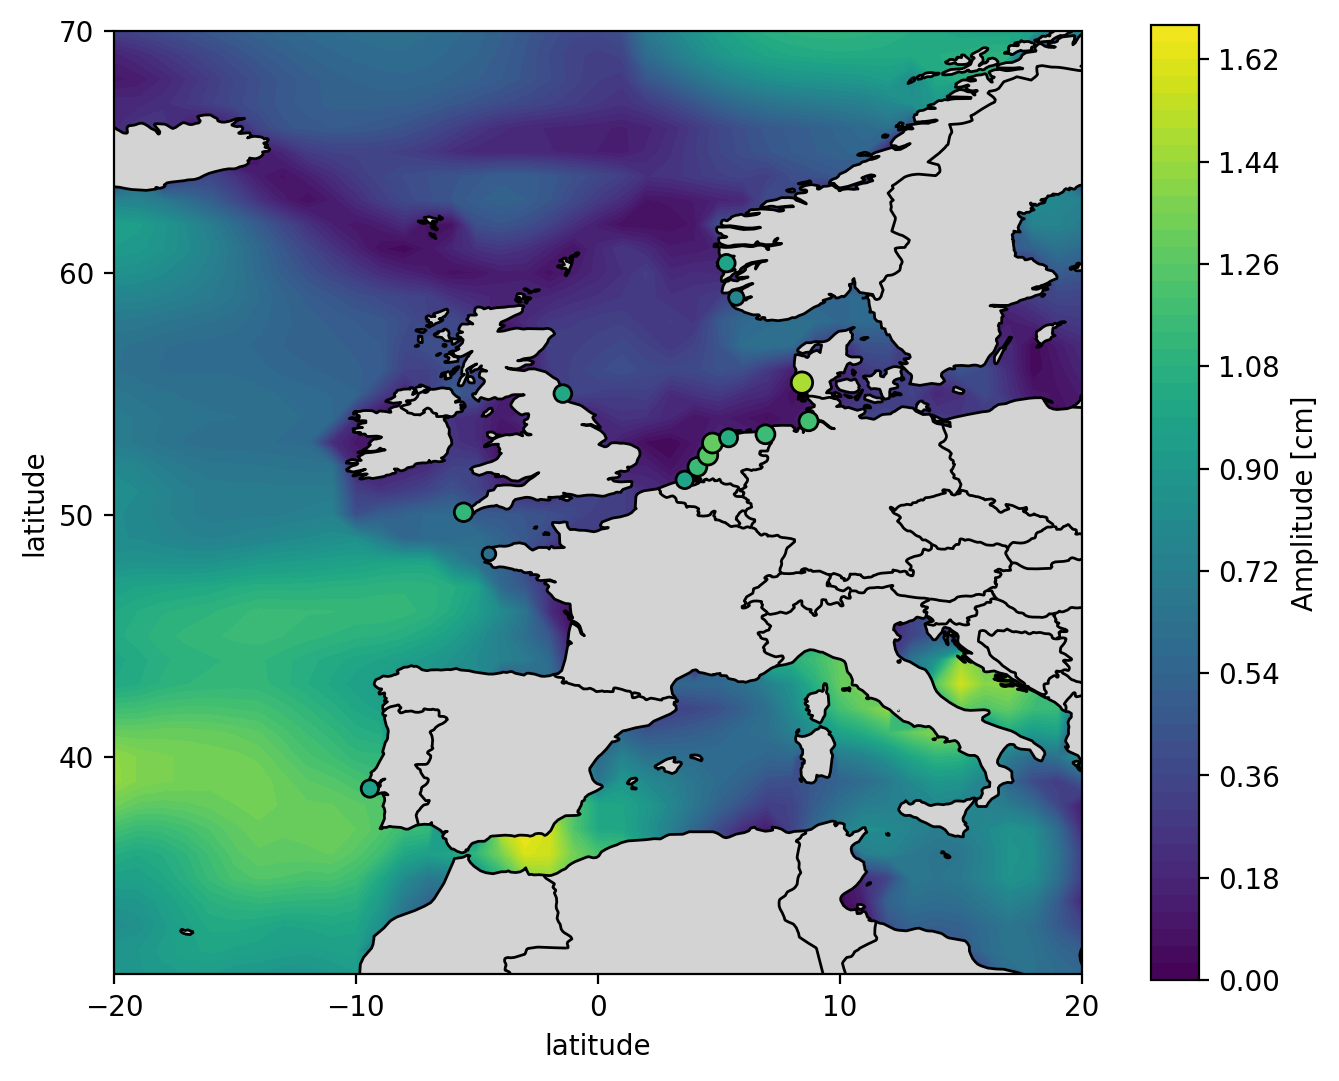

In [56]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

dampl2 = dampl.interpolate_na(dim='lat')
dampl2 = dampl2.interpolate_na(dim='lon')

tg = pd.read_csv(main +'output/tide_gauges/tidegauges.csv',index_col=0)
tg_aoe = tg['dA (obs-eq)']

im = plt.contourf(lons, lats, dampl2, 60,transform=ccrs.PlateCarree(),vmin=0,vmax=1.7,antialiased=False)

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(im,fraction=0.044, pad=0.001,label='Amplitude [cm]')

ax.set_xticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax.set_yticks([30,40,50,60,70], crs=ccrs.PlateCarree())
ax.set_ylim([31,70])

im.axes.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)    
im.axes.add_feature(cfeature.BORDERS)
im.axes.coastlines();

s_ampl = tg_aoe

ax.set_ylabel('latitude')
ax.set_xlabel('latitude')

plt.scatter(lons2,lats2,transform=ccrs.PlateCarree(),s=s_ampl*40,c=s_ampl,vmin=0,vmax=1.7,edgecolors='k',zorder=2);
#plt.savefig(path + '/figures/NodalAmplitudeStericSeaLevel_EN4.png', dpi=150)

In [57]:
max_depth = 400
region = "EBB"
start_year = 1960
end_year = 2020

In [58]:
StericSL_EBB_df = StericSL('EN4_22', 'EBB', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]

StericSL_df = StericSL_EBB_df

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:end_year]

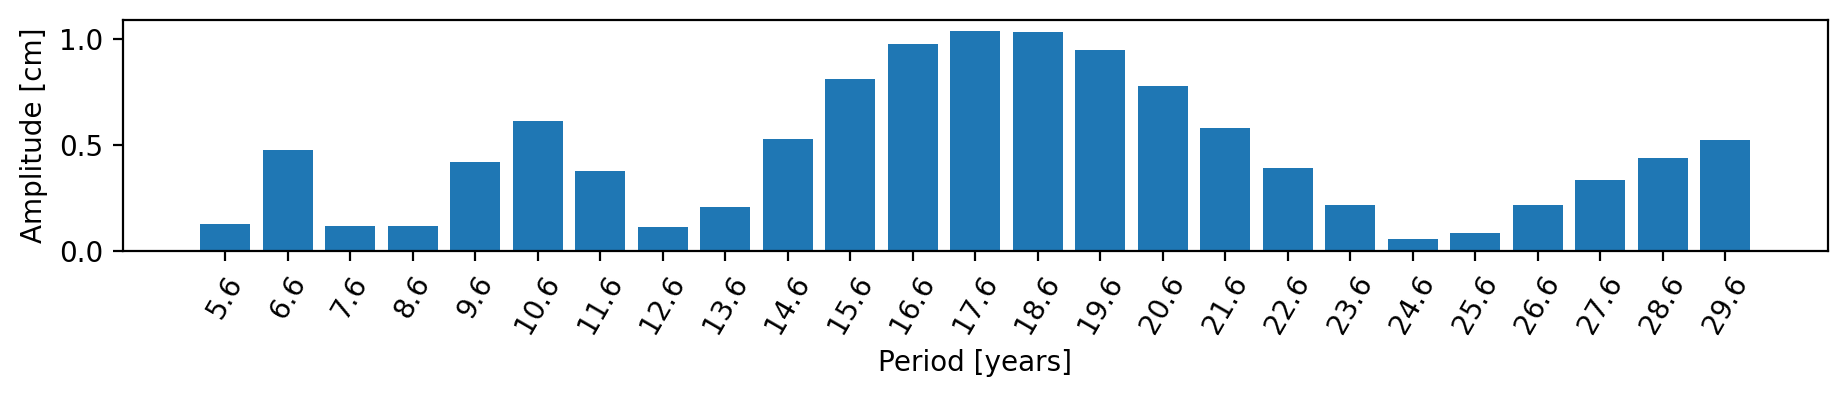

In [59]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

period = np.arange(5.6,30.6,1)

ampl = np.zeros(len(period))

for i in range(len(period)):
    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/period[i])
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/period[i])
    
    res_nr, res_full_nr = compute_model(reg_df)
    
    ampl[i] = res_nr["nodal_steric"].loc[1993:2011].max()
    
fig, ax = plt.subplots(figsize=(11,1.5))
plt.bar(period,ampl);
plt.xticks(period,rotation=60)
plt.xlabel('Period [years]')
plt.ylabel('Amplitude [cm]');

#plt.savefig(path + '/figures/periods.png', dpi=150,bbox_inches='tight')

## Nodal modulation of all signals

In [60]:
max_depth = 400
region = "EBB"
start_year = 1960
end_year = 2020

In [61]:
StericSL_EBB_df = StericSL('EN4_22', 'EBB', 0, max_depth, 0)

StericSL_EBB_df.columns = ["Steric_EBB"]

StericSL_df = StericSL_EBB_df

# Remove the first decades
StericSL_df = StericSL_df.loc[start_year:end_year]

In [62]:
t = StericSL_df.index

reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)

In [63]:
res_nr, res_full_nr = compute_model(reg_df)

In [66]:
def nodal_tides_potential(lat, time_years):
    '''Compute the nodal tide potential based on Woodworth et al. 2012,
    https://doi.org/10.2112/JCOASTRES-D-11A-00023.1'''
    
    h2 = 0.6032
    k2 = 0.298

    #nodal cycle correction
    A = 0.44*(1+k2-h2)*20*(3*np.sin(lat*np.pi/180.)**2-1)*1.20/10  # mm to cm
    nodcyc = A*np.cos((2*np.pi*(time_years-1922.7))/18.61 + np.pi)
    
    nodcyc_df = pd.DataFrame(data={'time': time_years, 'Nodal': nodcyc})
    nodcyc_df = nodcyc_df.set_index('time')
    
    return nodcyc_df

In [69]:
regions = ['Cascais','Brest','Newlyn','Vlissingen','Hoek van Holland','IJmuiden','Den Helder','Harlingen','Delfzijl','Cuxhaven','Esbjerg','North Shields','Stavanger','Bergen']

names = ['id','lat','lon','Amplitude eq+st','Amplitude eq','Amplitude obs','dA (obs-(eq+st))','dA (obs-eq)','Phase eq+st','Phase eq','Phase obs','dP (obs-(eq+st))','dP (obs-eq)','Amplitude st','Phase st']
ov = np.zeros([len(regions),15])

for i in range(len(regions)):
    gam = pd.read_csv(f"{main}output/tide_gauges/{regions[i]}/results_NearestPointAverage2.csv")
    gam.set_index("time", inplace=True)
    obs_nod = gam["nod1"]+gam["nod2"]
    obs_nod.name = "Observed cycle"
    
    tg_id, latitude = select_id(regions[i])
    
    lats, lons = tg_lat_lon(data_tidegauges_dir, tg_id)
        
    et = nodal_tides_potential(latitude, gam.index)
    et = et.rename(columns={"Nodal":"Equilibrium tide"})
    
    reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    
    res_nr, res_full_nr = compute_model(reg_df)
    
    nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])
    nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
    
    ov[i,0] = tg_id
    ov[i,1] = lats
    ov[i,2] = lons
    if regions[i] == 'Cascais':
        ov[i,6] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].max()
        ov[i,7] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1975:1993].max()
        ov[i,3] = nodal_df["Eq+Steric"].loc[1975:1993].max()
        ov[i,4] = nodal_df["Equilibrium tide"].loc[1975:1993].max()
        ov[i,5] = nodal_df["Observed cycle"].loc[1975:1993].max()
        ov[i,13] = nodal_df["nodal_steric"].loc[1975:1993].max()
        ov[i,8] = nodal_df["Eq+Steric"].loc[1975:1993].idxmax() + 18
        ov[i,9] = nodal_df["Equilibrium tide"].loc[1975:1993].idxmax() + 18
        ov[i,10] = nodal_df["Observed cycle"].loc[1975:1993].idxmax() + 18
    else:
        ov[i,6] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].max()
        ov[i,7] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1993:2011].max()
        ov[i,3] = nodal_df["Eq+Steric"].loc[1993:2011].max()
        ov[i,4] = nodal_df["Equilibrium tide"].loc[1993:2011].max()
        ov[i,5] = nodal_df["Observed cycle"].loc[1993:2011].max()
        ov[i,13] = nodal_df["nodal_steric"].loc[1993:2011].max()
        ov[i,8] = nodal_df["Eq+Steric"].loc[1993:2011].idxmax()
        ov[i,9] = nodal_df["Equilibrium tide"].loc[1993:2011].idxmax()
        ov[i,10] = nodal_df["Observed cycle"].loc[1993:2011].idxmax()
    if regions[i] == 'Cascais':
        ov[i,11] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].idxmax() + 18
        ov[i,12] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1975:1993].idxmax() + 18
        ov[i,14] = nodal_df["nodal_steric"].loc[1975:1993].idxmax() + 18
    else:
        ov[i,11] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].idxmax()
        ov[i,12] = (nodal_df["Observed cycle"] - nodal_df["Equilibrium tide"]).loc[1993:2011].idxmax()
        ov[i,14] = nodal_df["nodal_steric"].loc[1993:2011].idxmax()

#ov2 = pd.DataFrame(ov,columns=names,index=regions)
#ov2.to_csv(path + '/data/output/tide_gauges/tidegauges.csv')

In [71]:
std = np.loadtxt(main + 'output/standard_deviations.txt')

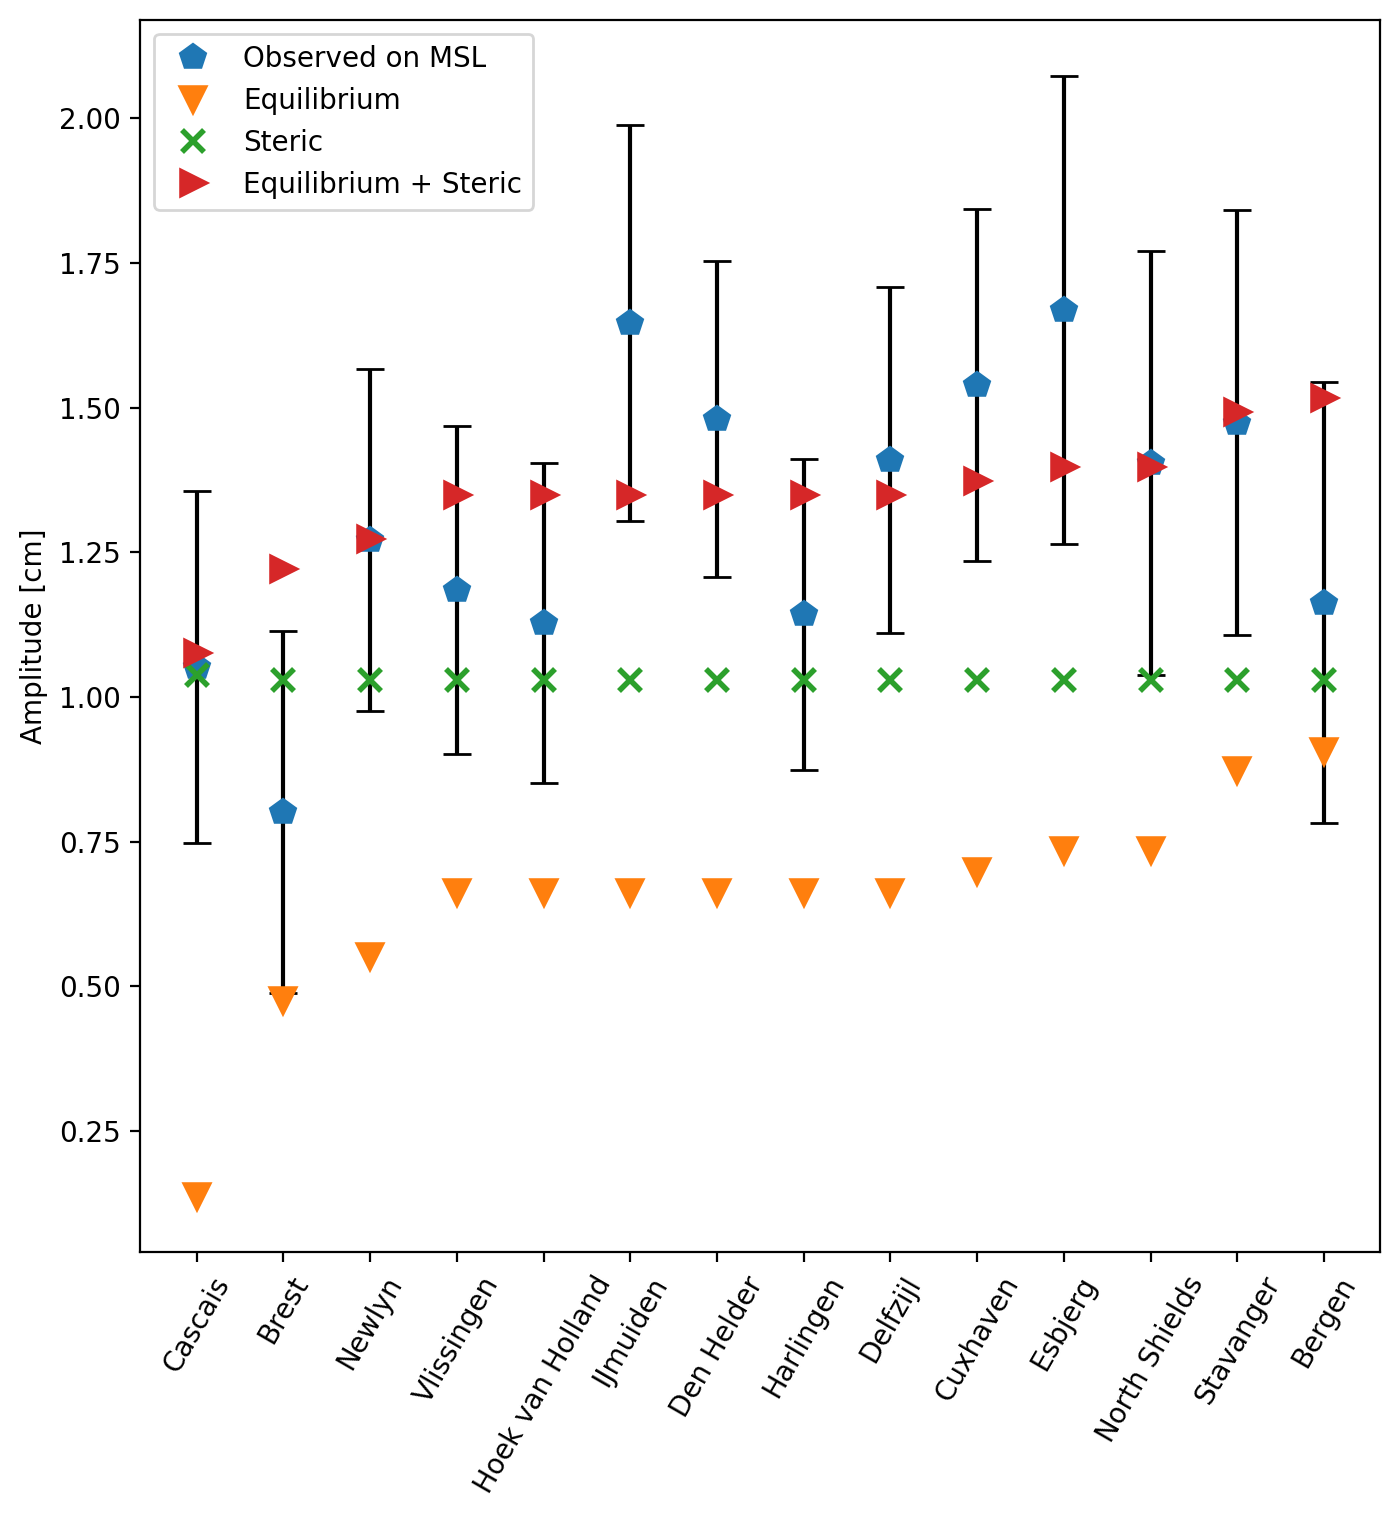

In [73]:
fig = plt.figure(figsize=(8,8))

x = np.linspace(0,14,14)

ov2_v = pd.read_csv(main + 'output/tide_gauges/tidegauges.csv')
mean = ov2_v['dA (obs-(eq+st))'].mean()
obs = ov2_v['Amplitude obs']

for i in range(len(regions)):
    plt.errorbar(x[i],obs[i],yerr=std[0,i],capsize=5,color='black')

plt.plot(x,ov2_v['Amplitude obs'],'p',label='Observed on MSL',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude eq'],'v',label='Equilibrium',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude st'],'x',label='Steric',mew=2,ms=8)
plt.plot(x,ov2_v['Amplitude eq+st'],'>',label='Equilibrium + Steric',mew=2,ms=8)
plt.ylabel('Amplitude [cm]')
plt.xticks(ticks=x,labels=regions,rotation = 60)
plt.legend();

#plt.savefig(path + '/figures/amplitudes.png', dpi=150,bbox_inches='tight')

The mean error of the phase: 0.8613571428571428


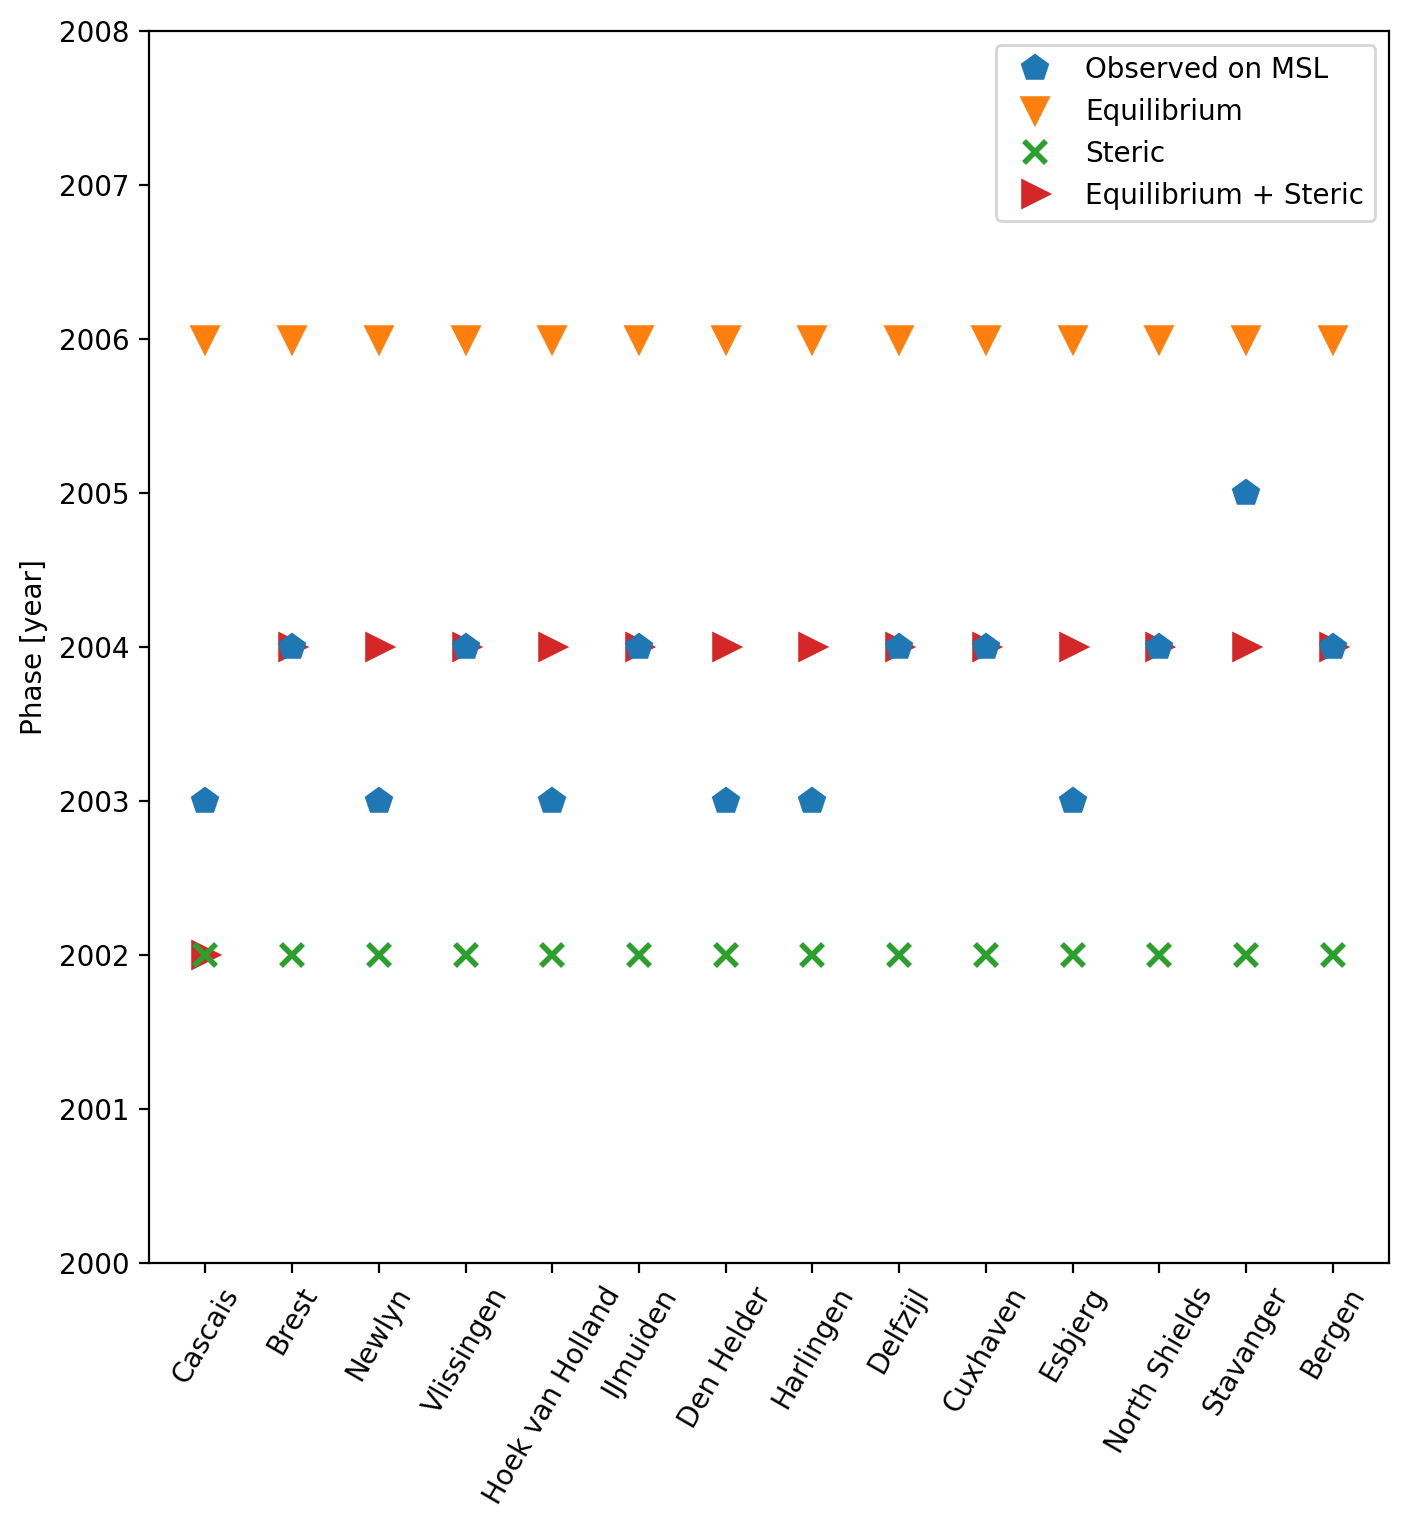

In [75]:
fig = plt.figure(figsize=(8,8))

x = np.linspace(0,14,14)

ov2_v = pd.read_csv(main + 'output/tide_gauges/tidegauges.csv')

error = std[1,:]
print(f'The mean error of the phase:',np.mean(error))

plt.plot(x,ov2_v['Phase obs'],'p',label='Observed on MSL',mew=2,ms=8,zorder=1)
plt.plot(x,ov2_v['Phase eq'],'v',label='Equilibrium',mew=2,ms=8)
plt.plot(x,ov2_v['Phase st'],'x',label='Steric',mew=2,ms=8)
plt.plot(x,ov2_v['Phase eq+st'],'>',label='Equilibrium + Steric',mew=2,ms=8,zorder=0)
plt.ylabel('Phase [year]')
plt.xticks(ticks=x,labels=regions,rotation = 60)
plt.legend();
#plt.xlim([])
plt.ylim([2000,2008]);

#plt.savefig(path + '/figures/phases.png', dpi=150,bbox_inches='tight')

## Comparison high-frequency tides and steric signal

In [77]:
m2 = np.loadtxt(main + 'input/M2-files/M2-BREST_without_nod_cor.txt')
m2_nc = np.loadtxt(main + 'input/M2-files/M2-BREST.txt')

cycles = pd.ExcelFile(main + 'input/Tidal_cycles.xlsx')
br = pd.read_excel(cycles, 'Brest', index_col=[0])

tg_id, latitude = select_id('Brest')

In [79]:
et = nodal_tides_potential(latitude, gam.index)
et = et.rename(columns={"Nodal":"Equilibrium tide"})

In [80]:
nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])

nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]

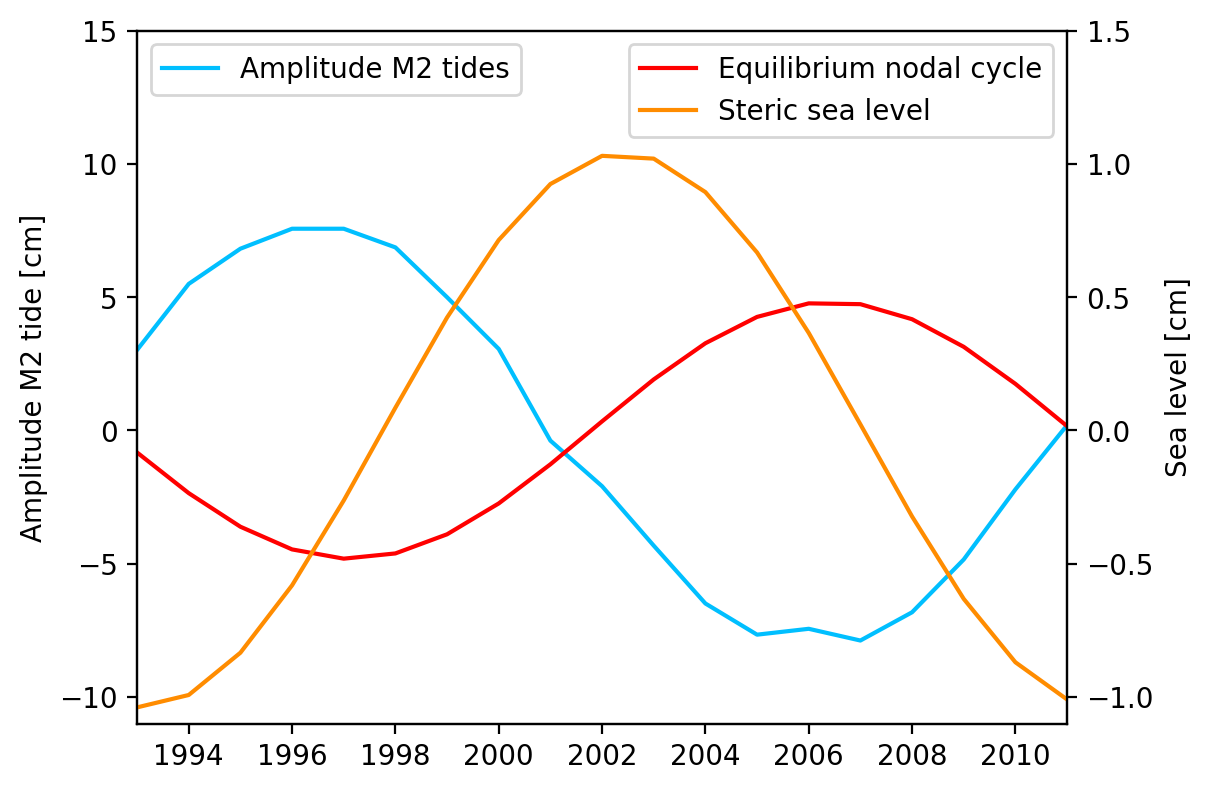

In [108]:
fig, ax = plt.subplots(figsize=(6,4.5))

ax.plot(m2[:,0],m2[:,1]-np.mean(m2[:,1]),'deepskyblue',label='Amplitude M2 tides')
ax.set_xlim([1993,2011])
ax.set_ylabel('Amplitude M2 tide [cm]')
ax.set_ylim([-11,15]);

ax2=ax.twinx()
ax2.plot(nodal_df[['Equilibrium tide']],'r',label='Equilibrium nodal cycle')
ax2.plot(nodal_df['nodal_steric'],'darkorange', label='Steric sea level')
ax2.set_ylabel('Sea level [cm]')
ax2.set_ylim([-1.1,1.5]);

ax.legend(loc='upper left')
ax2.legend(loc='upper right')
#fig.legend()

#plt.savefig('./figures/nodalcycle&tides_Brest.png', dpi=150, bbox_inches="tight")

## Density profile at different phases of steric signal

In [110]:
density_ds = xr.open_dataset(path_steric + 'density_teos10_en422_g10_1900_2022.nc')
density_ds_iap = xr.open_mfdataset(path_steric + 'density_teos10_IAP/density_teos10_iap_*.nc')

density = density_ds['density']
density_iap = density_ds_iap['density']

depth = density_ds['depth']

In [111]:
mask = steric_masks_north_sea(density, 'EBB')
SumDens = (density * mask).mean(dim=['lat', 'lon'])

sumdens2 = SumDens[:,0:26]

new = sumdens2.loc[1960:2021]
t = new.time

nodal = np.zeros((len(t),26))

for i in range(26):
    reg_df = new[:,i].to_dataframe()
    del reg_df['depth']

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    
    reg_df.columns = ['Steric','nod1','nod2']

    res_nr, res_full_nr = compute_model(reg_df)

    trend = res_nr.trend.iloc[0]

    res_nr['total'] = res_nr['total'] - res_nr['trend']
    nodal[:,i] = res_nr['total']

In [113]:
import scipy as sc

steric = pd.read_csv(main + 'input/nodal_steric.csv',index_col=0)
steric = steric.loc[1960:2020]

prof = np.zeros((4,26))

for i in range(26):
    der = steric.diff()

    peaks, _ = sc.signal.find_peaks(steric.values.flatten())
    troughs, _ = sc.signal.find_peaks(-steric.values.flatten())
    diff_max, _ = sc.signal.find_peaks(der.values.flatten())
    diff_min, _ = sc.signal.find_peaks(-der.values.flatten())
        
    prof[0,i] = nodal[peaks,i].mean()    
    prof[1,i] = nodal[troughs,i].mean() 
    prof[2,i] = nodal[diff_max,i].mean() 
    prof[3,i] = nodal[diff_min,i].mean() 

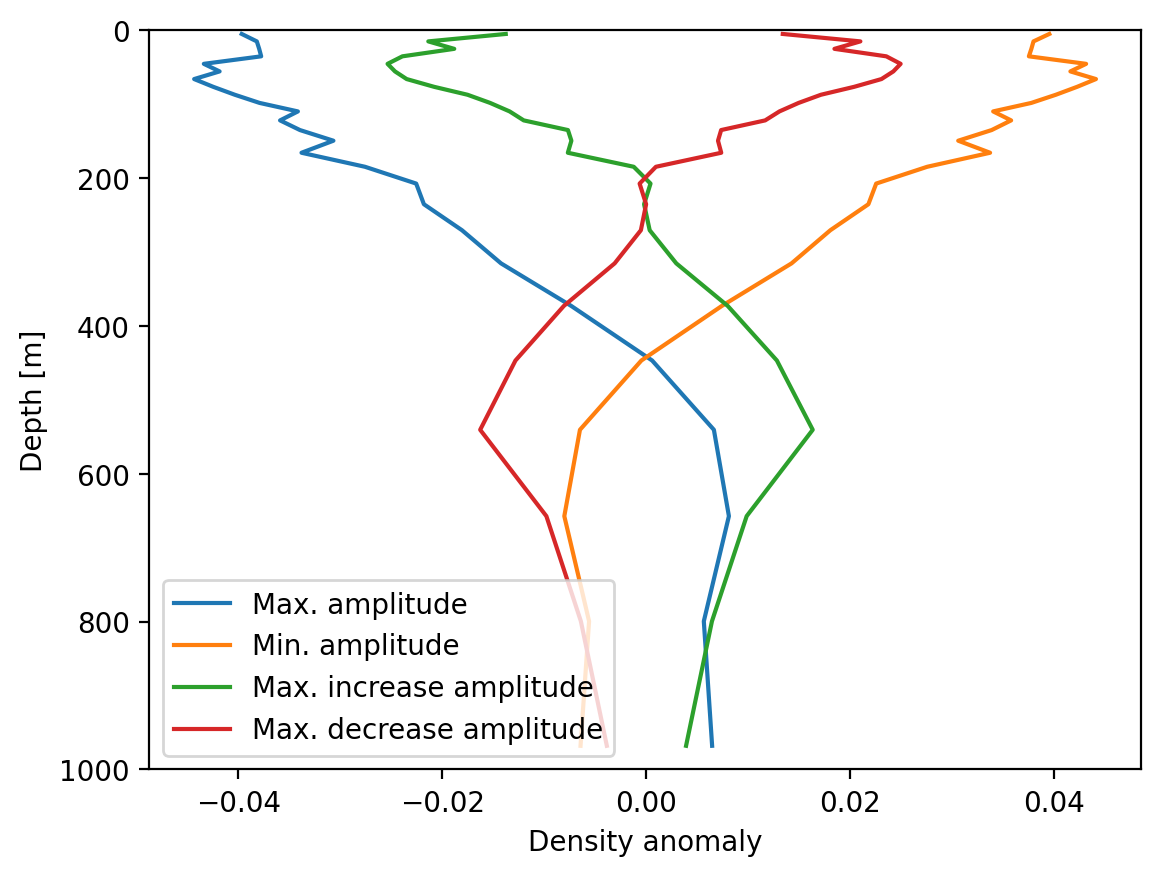

In [114]:
for i in range(0,4):
    plt.plot(prof[i,:],sumdens2['depth']);
plt.gca().invert_yaxis();
plt.ylim([1000,0]);
plt.ylabel('Depth [m]')
plt.xlabel('Density anomaly')
plt.legend(['Max. amplitude','Min. amplitude','Max. increase amplitude', 'Max. decrease amplitude']);

#plt.savefig(path + '/figures/profiles_EBB_EN4.png', dpi=150)

## Nodal amplitude and phase in density profile 

In [115]:
t =  sumdens2.time;
ampl_en4 = np.zeros(26)
norm_nodal = np.zeros((len(t),26))

for i in range(26):
    ampl_en4[i] = (nodal[:,i].max() - nodal[:,i].min())/2
    
phase_en4 = np.zeros(26)

t =  sumdens2.time.loc[1960:2021];
nodal = nodal[33:52,:]

for i in range(26):
    phase_en4[i] = t[int(nodal[:,i].argmin())] + 33

In [116]:
mask = steric_masks_north_sea(density_iap, 'EBB')
SumDens = (density_iap * mask).mean(dim=['lat', 'lon'])

sumdens2 = SumDens[:,0:26]

new = sumdens2.loc[1960:2021]
t = new.time

nodal = np.zeros((len(t),26))

for i in range(26):
    reg_df = new[:,i].to_dataframe()
    del reg_df['depth']

    reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
    reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
    
    reg_df.columns = ['Steric','nod1','nod2']

    res_nr, res_full_nr = compute_model(reg_df)

    trend = res_nr.trend.iloc[0]

    res_nr['total'] = res_nr['total'] - res_nr['trend']
    nodal[:,i] = res_nr['total']

In [117]:
t =  sumdens2.time;
ampl_iap = np.zeros(26)
norm_nodal = np.zeros((len(t),26))

for i in range(26):
    ampl_iap[i] = (nodal[:,i].max() - nodal[:,i].min())/2
    
phase_iap = np.zeros(26)

t =  sumdens2.time.loc[1960:2021];
nodal = nodal[33:52,:]

for i in range(26):
    phase_iap[i] = t[int(nodal[:,i].argmin())] + 33

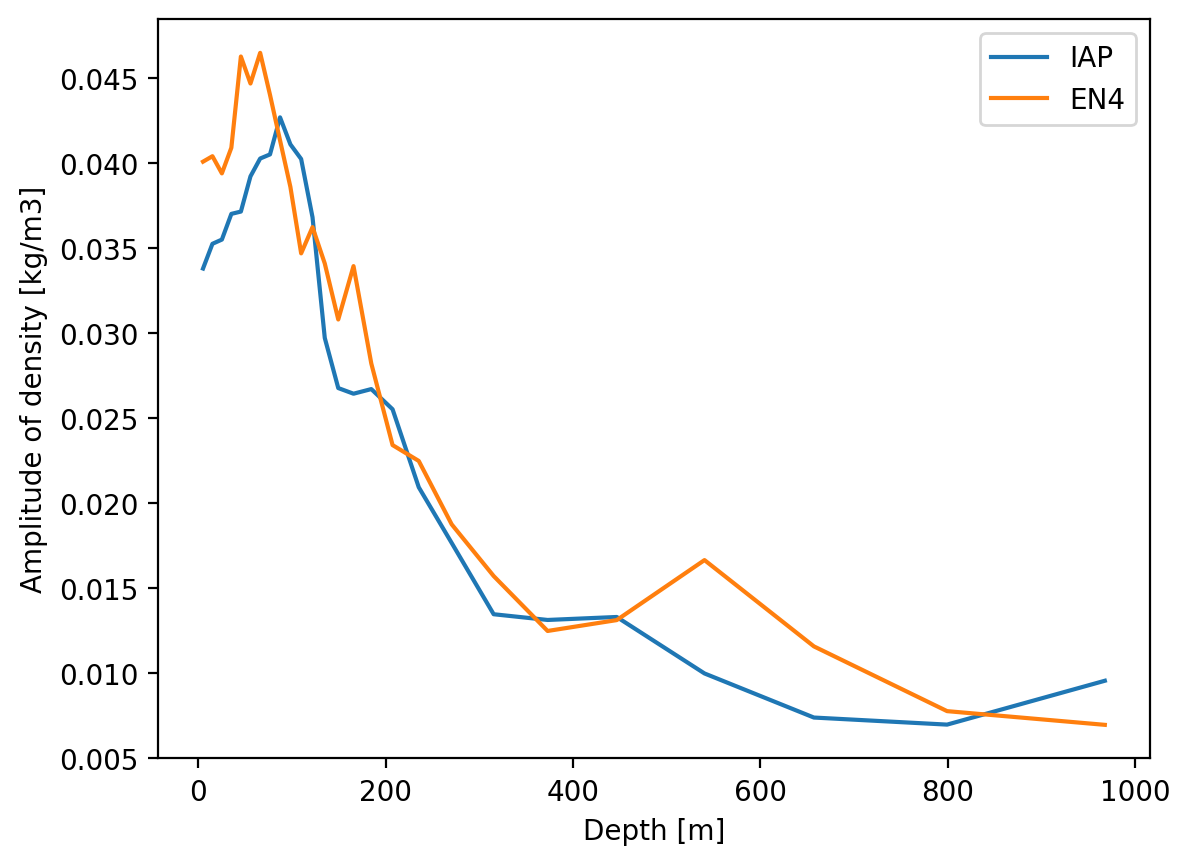

In [118]:
plt.plot(depth[0:26],ampl_iap,label='IAP')
plt.plot(depth[0:26],ampl_en4,label='EN4')
plt.ylabel('Amplitude of density [kg/m3]')
plt.xlabel('Depth [m]');
plt.legend();

#plt.savefig(path + '/figures/amplitude_density.png', dpi=150)

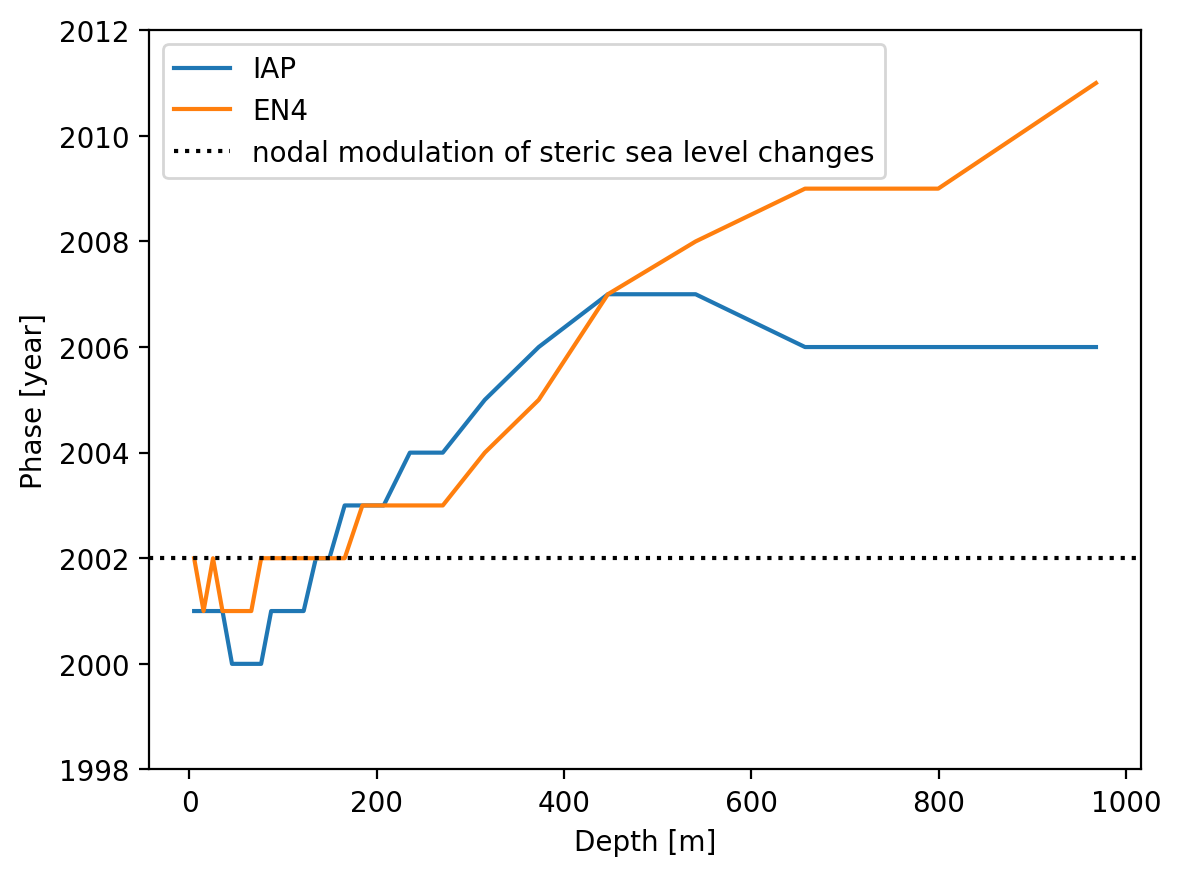

In [119]:
plt.plot(depth[0:26],phase_iap,label='IAP')
plt.plot(depth[0:26],phase_en4,label='EN4')

plt.axhline(2002,color='k',linestyle=':',label='nodal modulation of steric sea level changes')
plt.ylim([1998,2012]);
plt.ylabel('Phase [year]')
plt.xlabel('Depth [m]');
plt.legend(loc='upper left');

#plt.savefig(path + '/figures/phase_density.png', dpi=150)

# Supplementary material

In [120]:
max_depth = np.arange(100,2100,100)
region = "EBB"
start_year = np.arange(1940,1985,5)
end_year = 2020

In [124]:
ov = np.zeros((len(regions),len(max_depth),len(start_year)))
ph = np.zeros((len(regions),len(max_depth),len(start_year)))

for j in range(len(max_depth)):
    StericSL_EBB_df = StericSL('EN4_22', 'EBB', 0, max_depth[j], 0) #Change to EN4_22/IAP if the other figures are required

    StericSL_EBB_df.columns = ["Steric_EBB"]

    StericSL_df = StericSL_EBB_df

    for k in range(len(start_year)):
        start_year2 = start_year[k]
        StericSL_df = StericSL_df.loc[start_year2:end_year]
        
        t = StericSL_df.index

        reg_df = pd.DataFrame({'Steric':StericSL_df[f"Steric_{region}"]})

        reg_df['nod1'] = np.cos(2*np.pi*(t - t[0])/18.613)
        reg_df['nod2'] = np.sin(2*np.pi*(t - t[0])/18.613)
        
        for i in range(len(regions)):
            gam = pd.read_csv(f"{main}output/tide_gauges/{regions[i]}/results_NearestPointAverage2.csv")
            gam.set_index("time", inplace=True)
            obs_nod = gam["nod1"]+gam["nod2"]
            obs_nod.name = "Observed cycle"
            
            tg_id, latitude = select_id(regions[i])
           
            lats, lons = tg_lat_lon(data_tidegauges_dir, tg_id)

            et = nodal_tides_potential(latitude, gam.index)
            et = et.rename(columns={"Nodal":"Equilibrium tide"})
            
            reg_df['Steric'] = reg_df['Steric']
            
            gam_df = len(t)//2
            gam_alpha = 5000
                
            res_nr, res_full_nr = compute_model(reg_df)
    
            nodal_df = et.join([obs_nod,res_nr["nodal_steric"]])
            nodal_df["Eq+Steric"] = nodal_df["Equilibrium tide"] + nodal_df["nodal_steric"]
            
            if regions[i] == 'Cascais':
                ov[i,j,k] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1975:1993].max()
                ph[i,j,k] = nodal_df["Observed cycle"].loc[1975:1993].idxmax() - nodal_df["Eq+Steric"].loc[1975:1993].idxmax()
            else:
                ov[i,j,k] = (nodal_df["Observed cycle"] - nodal_df["Eq+Steric"]).loc[1993:2011].max()
                ph[i,j,k] = nodal_df["Observed cycle"].loc[1993:2011].idxmax() - nodal_df["Eq+Steric"].loc[1993:2011].idxmax()

In [125]:
ov2 = ov.mean(axis=0)
ph2 = ph.mean(axis=0)

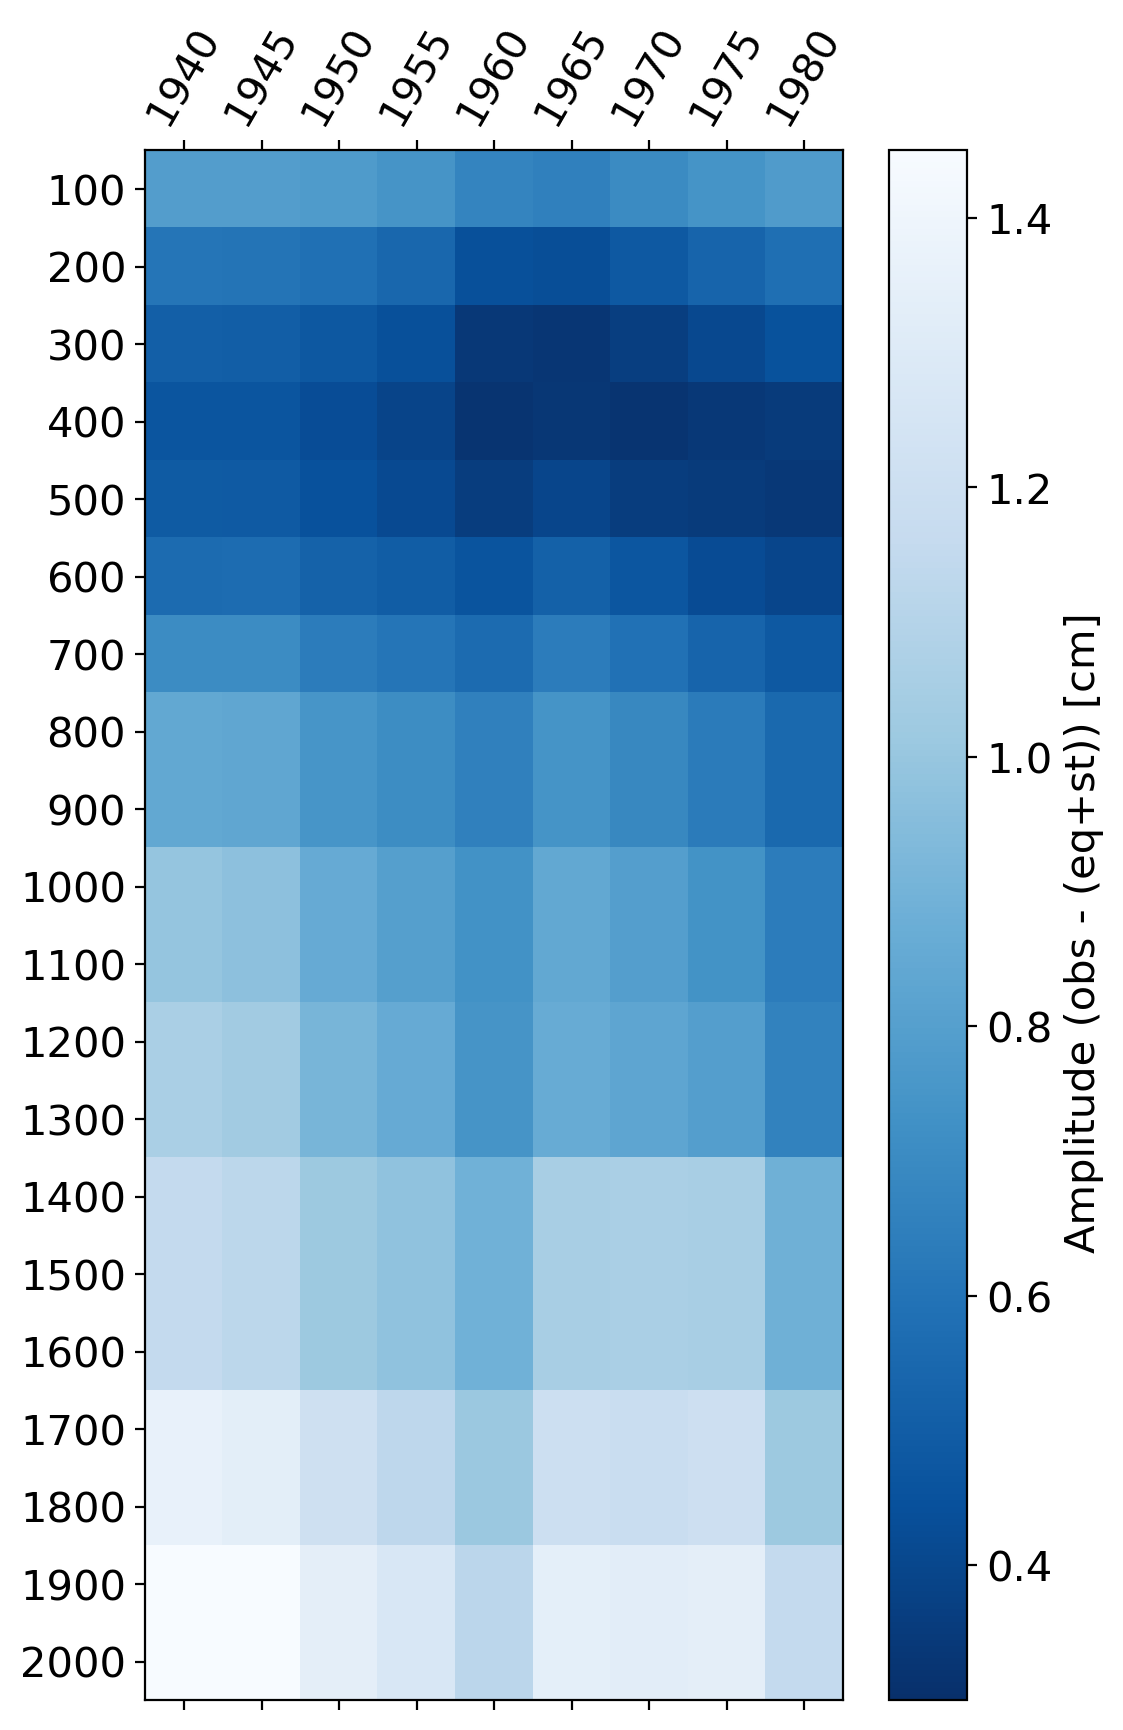

In [126]:
fig = plt.figure(figsize=(6,10));
plt.matshow(ov2,cmap='Blues_r',fignum=1,vmax=1.45,vmin=0.3)
cb = plt.colorbar(label='Amplitude (obs - (eq+st)) [cm] ')
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Amplitude (obs - (eq+st)) [cm] ',size=15)
plt.yticks(ticks=np.arange(0,20),labels=max_depth, fontsize=15)
plt.xticks(ticks=np.arange(0,9),labels=start_year,fontsize=15,rotation=60);

#plt.savefig(path + '/figures/Overview_amplitude_EN4.png', dpi=150)

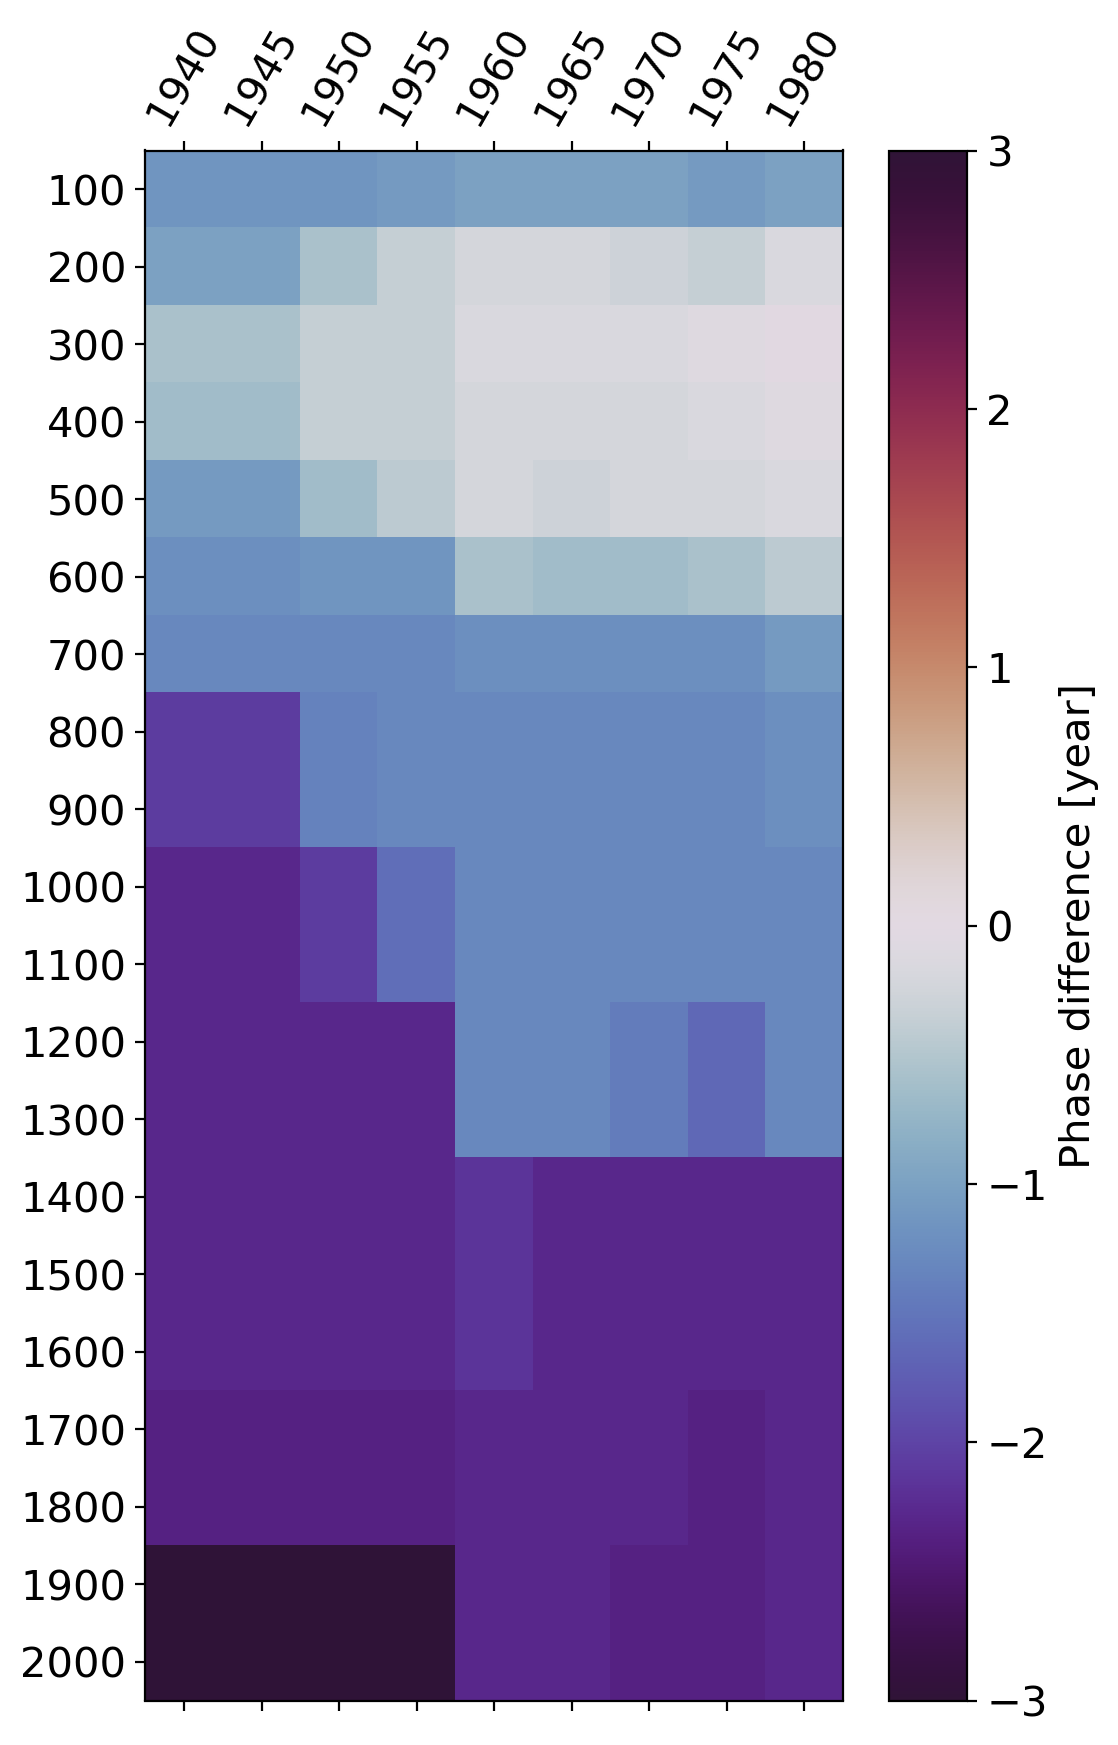

In [127]:
from matplotlib.colors import TwoSlopeNorm

fig = plt.figure(figsize=(6,10));
plt.matshow(ph2,cmap='twilight_shifted',fignum=1,norm=TwoSlopeNorm(vcenter=0,vmax=3,vmin=-3))
cb = plt.colorbar(label='Phase difference [year]',spacing='uniform')
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Phase difference [year]',size=15)
plt.clim([-3,3])
plt.yticks(ticks=np.arange(0,20),labels=max_depth, fontsize=15)
plt.xticks(ticks=np.arange(0,9),labels=start_year,fontsize=15,rotation=60);

cb.ax.set_yscale('linear')
#plt.savefig(path + '/figures/Overview_phase_v2_EN4.png', dpi=150)